# An Example of an Ad-hoc Analysis with coronavirus articles by Topic Modeling 

This is an example of how to perform an ad-hoc analysis with topic modeling.

In this example, articles from 3 brands within Bonnier News are chosen (Dagens Nyheter (DN), Dagens Industri (Di), and Expressen). The articles are tagged with the subject Corona virus. Then a topic modeling algorithm is applied to each of the 3 datasets to learn what concepts (topics) the different brands are writing about in the context of the coronavirus.

There are several settings that can be tuned for choosing which articles to be loaded from BigQuery, as well as hyperparameters for the algorithms. There are two different topic modeling algorithms implemented in this example, non-negative matrix factorization (NMF) and Latent Dirichlet Allocation (LDA).

In [1]:
# Necessary for importing modules from a sub-directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
if os.getcwd().split('/')[-1] == 'notebook_examples':
    os.chdir(r"../")


# Importing libraries
import pandas_gbq
import pickle
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models, corpora
from src.efselabwrapper.pipeline import run_processing_pipeline

## Data Settings
This is where the parameters are set for choosing which articles to perform topic modeling with.

In this example, 3 different datasets are loaded, with articles from Dagens Nyheter (DN), Dagens Industri (Di), and Expressen. Each dataset consists of 500 articles on the subject Corona virus. All articles are from the year 2020.

The number of articles needs to big enough to make the statistical relationships between the words reliable, hence giving meaningful topics. For advanced analysis we recommend this to be bigger than 5000, preferably around 10 000. To preprocess 10 000 articles takes about 1.5-2 minutes (which is the most time-consuming part of the modeling).

In [2]:
# General parameters for reading dataset from BigQuery


In [3]:
#Reading DN dataset from BigQuery

# TODO: READ DATA

Downloading: 100%|██████████| 500/500 [00:00<00:00, 659.91rows/s]


## Model Settings
This is where parameters for the modeling are chosen.
Part of Speech Tags (pos_tags) represents which Part of Speach classes are used in the modeling. In this example, all classes except nouns are filtered out.

The number of topics can be chosen as well as which algorithm to use. Which algorithm to use is highly use case dependent, hence there is no general best algorithm. A throughout comparison between the two algorithms can be found in our thesis (link in README), but as a short summary one can say that NMF is faster and creates more specific topics while LDA is slower and create more general and comprehensive topics.

In [10]:
# tags to choose:
# ['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV', 'SCONJ', 'AUX', 'PUNCT', 'ADP', 'PRON','DET', 'PART', 'CCONJ', 'NUM', 'INTJ']
pos_tags = ["NOUN"]

# Choose algorithm, LDA or NMF
algorithm = 'NMF' #'NMF' | 'LDA'

# Number of topics
NUM_TOPICS = 20

# NMF settings
NMF_NORM = 'frobenius' # ‘frobenius’ | ‘kullback-leibler’ | ‘itakura-saito’
NMF_SOLVER = 'mu' # ‘cd’ | ‘mu’
INIT = None # None | ‘random’ | ‘nndsvd’ | ‘nndsvda’ | ‘nndsvdar’ | ‘custom’
ALPHA = 0 # float

In [11]:
# Preprocess
efselab_parsed_corpus_DN = run_processing_pipeline(df_DN, pos_tags)
efselab_parsed_corpus_Di = run_processing_pipeline(df_Di, pos_tags)
efselab_parsed_corpus_Exp = run_processing_pipeline(df_Exp, pos_tags)

## Build Topic Models

In [12]:
if algorithm == 'LDA':
    # Set mallet path
    mallet_path ='src/mallet-2.0.8/bin/mallet'
    
    # Format Gensim components for DN preprocessed corpus
    id2word_DN = corpora.Dictionary(efselab_parsed_corpus_DN)
    id2word_DN.filter_extremes(no_below=2)
    corpus_DN = [id2word_DN.doc2bow(text) for text in efselab_parsed_corpus_DN]

    # Train DN model
    model_DN = models.wrappers.LdaMallet(mallet_path,
                                      corpus=corpus_DN,
                                      id2word=id2word_DN,
                                      num_topics=NUM_TOPICS)
    topics_DN = model_DN.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False)    
    doc_topic_weights_DN = np.array([[e[1] for e in doc] for doc in model_DN[corpus_DN]])

    # Format Gensim components for Di preprocessed corpus
    id2word_Di = corpora.Dictionary(efselab_parsed_corpus_Di)
    id2word_Di.filter_extremes(no_below=2)
    corpus_Di = [id2word_Di.doc2bow(text) for text in efselab_parsed_corpus_Di]

    # Train Di model
    model_Di = models.wrappers.LdaMallet(mallet_path,
                                      corpus=corpus_Di,
                                      id2word=id2word_Di,
                                      num_topics=NUM_TOPICS)
    topics_Di = model_Di.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False)    
    doc_topic_weights_Di = np.array([[e[1] for e in doc] for doc in model_Di[corpus_Di]])
    
    # Format Gensim components for Exp preprocessed corpus
    id2word_Exp = corpora.Dictionary(efselab_parsed_corpus_Exp)
    id2word_Exp.filter_extremes(no_below=2)
    corpus_Exp = [id2word_Exp.doc2bow(text) for text in efselab_parsed_corpus_Exp]

    # Train Exp model
    model_Exp = models.wrappers.LdaMallet(mallet_path,
                                      corpus=corpus_Exp,
                                      id2word=id2word_Exp,
                                      num_topics=NUM_TOPICS)
    topics_Exp = model_Exp.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False)    
    doc_topic_weights_Exp = np.array([[e[1] for e in doc] for doc in model_Exp[corpus_Exp]])
    
if algorithm == 'NMF':
    # Create TF-IDF
    vectorizer = TfidfVectorizer(
        lowercase=False,
        tokenizer=lambda x: x,
        max_df=0.95,
        min_df=2,
        max_features=None,
        use_idf=True
    )
    
    def get_NMF_topics(model, feature_names, n_top_words):
        all_topics = []
        for topic_idx, topic in enumerate(model.components_):
            sumtopic = np.sum(topic)
            topic_formatted = (topic_idx, [(feature_names[i], topic[i]/sumtopic) for i in topic.argsort()[:-n_top_words - 1:-1]])
            all_topics.append(topic_formatted)
        return all_topics
    
    # DN tf_idf
    tf_idf_DN = vectorizer.fit_transform(efselab_parsed_corpus_DN)
    feature_names_DN = vectorizer.get_feature_names()
    
    # Train DN model
    model_DN = NMF(random_state=0, tol=0.0001, verbose=0, shuffle=False,\
            n_components=NUM_TOPICS, beta_loss=NMF_NORM, solver=NMF_SOLVER, \
            init=INIT, alpha=ALPHA, max_iter=500)
    W_DN = model_DN.fit_transform(tf_idf_DN, y=feature_names_DN)
    H_DN = model_DN.components_
    topics_DN = get_NMF_topics(model_DN, feature_names_DN, 10)
    doc_topic_weights_DN = W_DN
    
    # Di tf_idf
    tf_idf_Di = vectorizer.fit_transform(efselab_parsed_corpus_Di)
    feature_names_Di = vectorizer.get_feature_names()
    
    # Train Di model
    model_Di = NMF(random_state=0, tol=0.0001, verbose=0, shuffle=False,\
            n_components=NUM_TOPICS, beta_loss=NMF_NORM, solver=NMF_SOLVER, \
            init=INIT, alpha=ALPHA, max_iter=500)
    W_Di = model_Di.fit_transform(tf_idf_Di, y=feature_names_Di)
    H_Di = model_Di.components_
    topics_Di = get_NMF_topics(model_Di, feature_names_Di, 10)
    doc_topic_weights_Di = W_Di

    # Exp tf_idf
    tf_idf_Exp = vectorizer.fit_transform(efselab_parsed_corpus_Exp)
    feature_names_Exp = vectorizer.get_feature_names()
    
    # Train Exp model
    model_Exp = NMF(random_state=0, tol=0.0001, verbose=0, shuffle=False,\
            n_components=NUM_TOPICS, beta_loss=NMF_NORM, solver=NMF_SOLVER, \
            init=INIT, alpha=ALPHA, max_iter=500)
    W_Exp = model_Exp.fit_transform(tf_idf_Exp, y=feature_names_Exp)
    H_Exp = model_Exp.components_
    topics_Exp = get_NMF_topics(model_Exp, feature_names_Exp, 10)
    doc_topic_weights_Exp = W_Exp
    
doc_topic_DN = [np.argmax(e) for e in doc_topic_weights_DN]
topic_counts_DN = [doc_topic_DN.count(i) for i in range(len(topics_DN))]

doc_topic_Di = [np.argmax(e) for e in doc_topic_weights_Di]
topic_counts_Di = [doc_topic_Di.count(i) for i in range(len(topics_Di))]

doc_topic_Exp = [np.argmax(e) for e in doc_topic_weights_Exp]
topic_counts_Exp = [doc_topic_Exp.count(i) for i in range(len(topics_Exp))]

## Print Topics


 Topics DN 

T1: virus coronavirus land smitta utbrott spridning myndighet sjukdom risk värld 
T2: patient vård sjukhus region intensivvård läkare sjukvård personal behov covidpatient 
T3: företag krona miljard regering stöd stat peng kostnad finansminister korttidspermittering 
T4: vaccin dos spruta vaccinering miljon effektivitet bolag vaccination fas godkännande 
T5: region folkhälsomyndighet smittspridning råd smittspårning resa rekommendation ansvar smittskyddsläkare besked 
T6: match spelare klubb liga säsong lag träning träningsmatch fotboll publik 
T7: äldreboende boende läkare personal stad äldreomsorg riktlinje smitta familjeläkare skyddsutrustning 
T8: barn familj liv förskola hustru mamma miljon jobb pappa ungdom 
T9: land premiärminister polis regering hälsominister demonstration protest söndag regel tisdag 
T10: tävling lopp augusti coronapandemi mästerskap arrangör grund september göteborgsvarv löpare 
T11: antal land siffra ökning dödsfall statistik kurva restriktion s

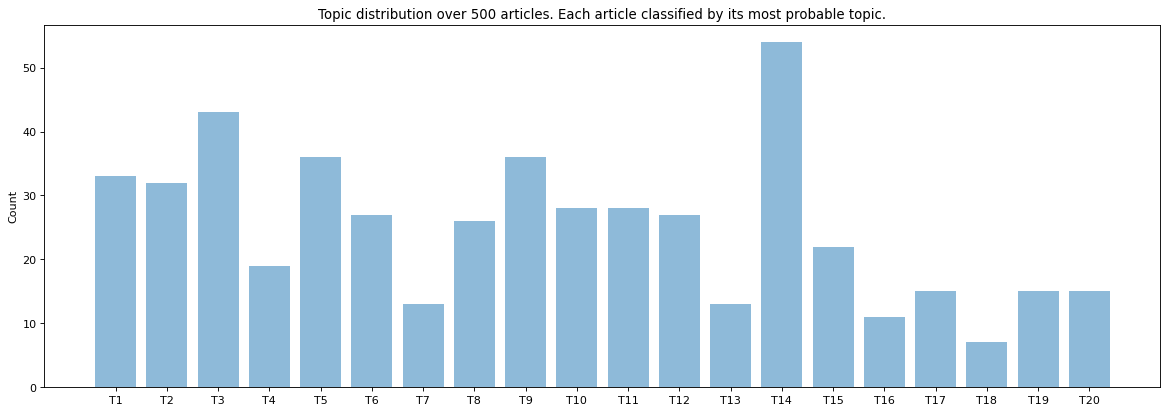

In [13]:
print('\n', 'Topics DN', '\n')

for topic in topics_DN:
    print(f'T{topic[0]+1}:', ' '.join([f'{e[0]}' for e in topic[1]]), '')
    
# Plot bar chart
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
topic_axis = [f'T{i+1}' for i in range(len(topics_DN))]
y_pos = np.arange(len(topic_axis))
plt.bar(y_pos, topic_counts_DN, align='center', alpha=0.5)
plt.xticks(y_pos, topic_axis)
plt.ylabel('Count')
plt.title(f'Topic distribution over {sum(topic_counts_DN)} articles. Each article classified by its most probable topic.')
plt.show()

In [14]:
import pyLDAvis
pyLDAvis.enable_notebook()

if algorithm == 'LDA':
    import pyLDAvis.gensim
    conv_model_DN = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_DN)
    
if algorithm == 'NMF':
    W_norm_DN = W_DN / W_DN.sum(axis=1)[:, None]
    H_smooth_DN = np.add(H_DN, 0.000000000001)
    H_norm_DN = H_smooth_DN / H_smooth_DN.sum(axis=1)[:, None]
    term_freq_DN = tf_idf_DN.sum(axis=0).getA1()
    doc_len_DN = tf_idf_DN.sum(axis=1).getA1()

    opts_DN = {'vocab': feature_names_DN, 
            'doc_lengths': doc_len_DN.tolist(),
            'term_frequency': term_freq_DN.tolist(),
            'doc_topic_dists': W_norm_DN.tolist(),
            'topic_term_dists': H_norm_DN.tolist(),
            'sort_topics': False
           }
    
pyLDAvis.gensim.prepare(conv_model_DN, corpus_DN, id2word_DN, sort_topics=False) if algorithm == 'LDA' else pyLDAvis.prepare(**opts_DN)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.064022  0.048501       1        1  9.672879
1      0.245116 -0.140646       2        1  6.161600
2     -0.083739 -0.002652       3        1  7.978821
3      0.158125  0.202584       4        1  3.155962
4      0.040258 -0.175841       5        1  5.578094
5     -0.153044  0.007161       6        1  4.042844
6      0.155373 -0.166588       7        1  3.837420
7     -0.060948  0.010729       8        1  5.392321
8     -0.144293  0.166108       9        1  5.823538
9     -0.143316 -0.039429      10        1  4.451622
10    -0.059815 -0.010580      11        1  5.947258
11    -0.103839  0.013809      12        1  5.883014
12     0.036283 -0.019900      13        1  3.752025
13    -0.036968  0.002504      14        1  9.004162
14    -0.063015  0.229789      15        1  4.269348
15    -0.115944 -0.096869      16        1  3.110520
16    -0.011507 -0.177317      17        1  3.101948
17     0.262542  0.163291      18        1  2.276810
18     0.168908  0.030445      19        1  3.200898
19    -0.154197 -0.045100      20        1  3.358914, topic_info=             Term       Freq      Total Category  logprob  loglift
3335       vaccin  12.000000  12.000000  Default  30.0000  30.0000
2381       region  17.000000  17.000000  Default  29.0000  29.0000
2670        skola   9.000000   9.000000  Default  28.0000  28.0000
1956     munskydd   9.000000   9.000000  Default  27.0000  27.0000
2181      patient  11.000000  11.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
233   begränsning   0.532241   2.096716  Topic20  -5.2718   2.0225
1653         land   0.717151  17.266044  Topic20  -4.9736   0.2123
2372     regering   0.683741  13.878946  Topic20  -5.0213   0.3830
144      arrangör   0.539386   3.081800  Topic20  -5.2584   1.6507
652     evenemang   0.517515   3.672043  Topic20  -5.2998   1.4341

[1202 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
0         3  1.067946         a_kassa
4         9  1.506472          adress
19        3  0.910965  aktieutdelning
27        2  1.003166     akutsjukhus
37        6  1.463585      allsvenska
...     ...       ...             ...
3572      2  0.181931          ökning
3572      5  0.181931          ökning
3572     11  0.545794          ökning
3581     13  1.566796        öppnande
3587     11  0.601668   överdödlighet

[942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 Topics Di 

T1: virus land coronavirus myndighet stad restriktion fredag smitta antal måndag 
T2: företag kris vd miljard stöd regering näringsliv kostnad bransch omsättning 
T3: kvartal bolag försäljning efterfrågan mkr tillväxt coronavirus statistik utveckling nedgång 
T4: vaccin avtal fas forskare test coronavaccin försök dos försöksperson miljon 
T5: antal dygn dödsfall miljon siffra land ökning covid_19 statistik intensivvård 
T6: utdelning bolag aktie styrelse krona pressmeddelande årsstämma utdelningsförslag förslag osäkerhet 
T7: folkhälsomyndighet region socialstyrelse siffra sjukvård pressträff sjukhus statsepidemiolog test hand 
T8: bank finansinspektion lån ekonomi läge buffert problem storbank uppmaning system 
T9: fabrik produktion bil leverantör måndag produktionsstopp leverans komponent tidning mars 
T10: krona miljard dollar euro miljon lån fond program coronapandemi skuld 
T11: land gräns karantän turist medborgare besökare resenär premiärminister juli turism 
T12: 

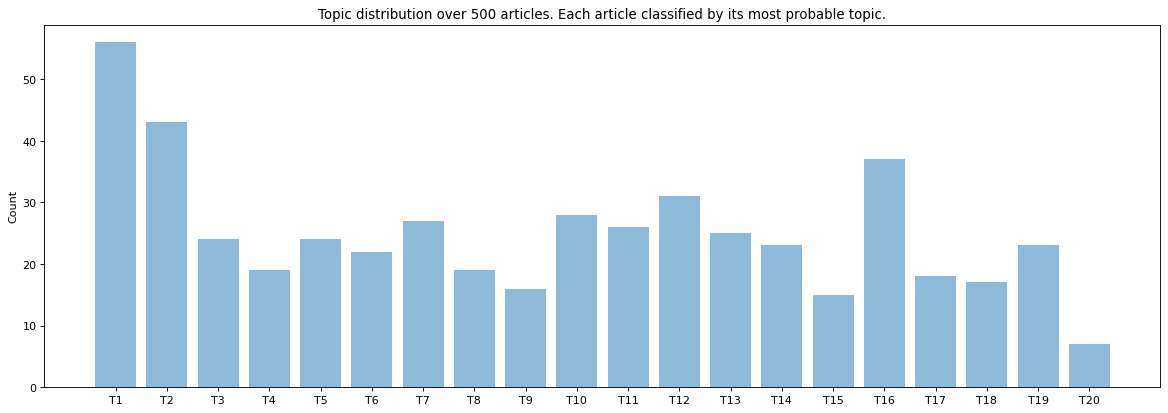

In [15]:
print('\n', 'Topics Di', '\n')

for topic in topics_Di:
    print(f'T{topic[0]+1}:', ' '.join([f'{e[0]}' for e in topic[1]]), '')
    
# Plot bar chart
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
topic_axis = [f'T{i+1}' for i in range(len(topics_Di))]
y_pos = np.arange(len(topic_axis))
plt.bar(y_pos, topic_counts_Di, align='center', alpha=0.5)
plt.xticks(y_pos, topic_axis)
plt.ylabel('Count')
plt.title(f'Topic distribution over {sum(topic_counts_Di)} articles. Each article classified by its most probable topic.')
plt.show()

In [16]:
import pyLDAvis
pyLDAvis.enable_notebook()

if algorithm == 'LDA':
    import pyLDAvis.gensim
    conv_model_Di = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_Di)
    
if algorithm == 'NMF':
    W_norm_Di = W_Di / W_Di.sum(axis=1)[:, None]
    H_smooth_Di = np.add(H_Di, 0.000000000001)
    H_norm_Di = H_smooth_Di / H_smooth_Di.sum(axis=1)[:, None]
    term_freq_Di = tf_idf_Di.sum(axis=0).getA1()
    doc_len_Di = tf_idf_Di.sum(axis=1).getA1()

    opts_Di = {'vocab': feature_names_Di, 
            'doc_lengths': doc_len_Di.tolist(),
            'term_frequency': term_freq_Di.tolist(),
            'doc_topic_dists': W_norm_Di.tolist(),
            'topic_term_dists': H_norm_Di.tolist(),
            'sort_topics': False
           }
    
pyLDAvis.gensim.prepare(conv_model_Di, corpus_Di, id2word_Di, sort_topics=False) if algorithm == 'LDA' else pyLDAvis.prepare(**opts_Di)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.084054 -0.011829       1        1  12.350992
1     -0.190738 -0.049197       2        1   8.815639
2     -0.157365  0.122429       3        1   4.624977
3      0.155416  0.188485       4        1   3.752639
4      0.260200 -0.059233       5        1   3.920303
5     -0.198594  0.040656       6        1   4.271748
6      0.115633  0.093928       7        1   5.662362
7     -0.142906 -0.034378       8        1   3.826516
8     -0.107399  0.028708       9        1   3.121189
9     -0.043600 -0.106369      10        1   4.964452
10     0.114506 -0.185491      11        1   5.073276
11    -0.057753 -0.029559      12        1   6.924956
12     0.176869 -0.055994      13        1   4.391254
13    -0.090924 -0.126994      14        1   4.579899
14    -0.108923  0.021959      15        1   4.043255
15    -0.138546 -0.045899      16        1   6.788605
16     0.077575  0.260886      17        1   3.078803
17     0.221188 -0.167406      18        1   2.982732
18    -0.029341 -0.127357      19        1   5.017460
19     0.060650  0.242654      20        1   1.808944, topic_info=            Term       Freq      Total Category  logprob  loglift
58         antal  15.000000  15.000000  Default  30.0000  30.0000
1047        land  21.000000  21.000000  Default  29.0000  29.0000
123         bank  11.000000  11.000000  Default  28.0000  28.0000
2114      vaccin  10.000000  10.000000  Default  27.0000  27.0000
1018     kvartal  11.000000  11.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
789    infektion   0.351605   1.319888  Topic20  -4.8425   2.6896
1848      ställe   0.407884   2.297128  Topic20  -4.6940   2.2840
389       effekt   0.360637   6.384485  Topic20  -4.8171   1.1387
945   konsekvens   0.315203   3.743366  Topic20  -4.9518   1.5379
1528      region   0.299994  12.086862  Topic20  -5.0012   0.3163

[1099 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2        13  1.365064        advokat
8         1  1.684691     affärsresa
12        3  0.120472          aktie
12        6  0.602359          aktie
12       16  0.120472          aktie
...     ...       ...            ...
2249      5  0.583830         ökning
2249      7  0.194610         ökning
2254     15  0.825430       öppettid
2255     11  0.910375       öppnande
2257     11  1.499892  öppningsdatum

[895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])


 Topics Expressen 

T1: antal smittspridning ökning utbrott smitta folkhälsomyndighet höst siffra land våg 
T2: dödsfall folkhälsomyndighet götalandsregion fredag region följd antal siffra dygn dygnssiffra 
T3: vaccin dos försök resultat coronavaccin avtal biverkning coronavirus miljon test 
T4: region smittskyddsläkare råd test götalandsregion pressmeddelande kapacitet arbetsgivare självtest län 
T5: skola elev distansundervisning lärare undervisning gymnasieskola distans skolstart gymnasieelev gymnasium 
T6: barn förälder symtom skola sjukdom corona dotter ungdom familj våld 
T7: munskydd krav kollektivtrafik passagerare färja resa resenär myndighet rekommendation finländare 
T8: gräns norrman region regering besked karantän lista svensk gränshandel statsminister 
T9: folk turist avstånd trängsel strand restaurang svensk plats hotell plan 
T10: äldreboende kommun boende regering pappa besöksförbud broder smitta äldreomsorg vård 
T11: sjukhus patient president personal avdelning beha

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


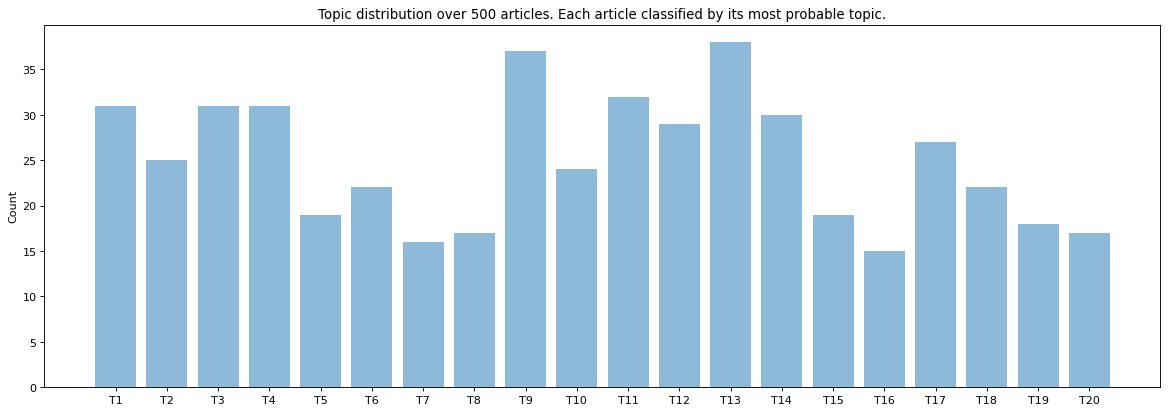

In [17]:
print('\n', 'Topics Expressen', '\n')

for topic in topics_Exp:
    print(f'T{topic[0]+1}:', ' '.join([f'{e[0]}' for e in topic[1]]), '')
    
# Plot bar chart
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
topic_axis = [f'T{i+1}' for i in range(len(topics_Exp))]
y_pos = np.arange(len(topic_axis))
plt.bar(y_pos, topic_counts_Exp, align='center', alpha=0.5)
plt.xticks(y_pos, topic_axis)
plt.ylabel('Count')
plt.title(f'Topic distribution over {sum(topic_counts_Exp)} articles. Each article classified by its most probable topic.')
plt.show()

In [18]:
import pyLDAvis
pyLDAvis.enable_notebook()

if algorithm == 'LDA':
    import pyLDAvis.gensim
    conv_model_Exp = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_Exp)
    
if algorithm == 'NMF':
    W_norm_Exp = W_Exp / W_Exp.sum(axis=1)[:, None]
    H_smooth_Exp = np.add(H_Exp, 0.000000000001)
    H_norm_Exp = H_smooth_Exp / H_smooth_Exp.sum(axis=1)[:, None]
    term_freq_Exp = tf_idf_Exp.sum(axis=0).getA1()
    doc_len_Exp = tf_idf_Exp.sum(axis=1).getA1()

    opts_Exp = {'vocab': feature_names_Exp, 
            'doc_lengths': doc_len_Exp.tolist(),
            'term_frequency': term_freq_Exp.tolist(),
            'doc_topic_dists': W_norm_Exp.tolist(),
            'topic_term_dists': H_norm_Exp.tolist(),
            'sort_topics': False
           }
    
pyLDAvis.gensim.prepare(conv_model_Exp, corpus_Exp, id2word_Exp, sort_topics=False) if algorithm == 'LDA' else pyLDAvis.prepare(**opts_Exp)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.029756 -0.094623       1        1  9.696954
1      0.078667 -0.251448       2        1  3.906990
2      0.182980 -0.022175       3        1  5.036698
3      0.046031  0.123295       4        1  5.898583
4     -0.155147 -0.134251       5        1  3.467215
5      0.141193  0.033764       6        1  3.965117
6     -0.170515 -0.044857       7        1  4.197903
7     -0.086373  0.054556       8        1  4.861261
8     -0.121154  0.114454       9        1  7.272381
9      0.047820  0.153180      10        1  4.970444
10     0.159586  0.063362      11        1  5.732278
11    -0.050218 -0.221870      12        1  4.602187
12    -0.056724  0.202241      13        1  7.173401
13    -0.087417  0.034642      14        1  5.037799
14     0.236374 -0.049043      15        1  3.712627
15    -0.240415  0.005430      16        1  2.752939
16     0.152611 -0.045206      17        1  5.320702
17    -0.066420 -0.036331      18        1  4.511157
18    -0.075809 -0.050254      19        1  3.455568
19     0.035173  0.165135      20        1  4.427795, topic_info=            Term       Freq      Total Category  logprob  loglift
2315      vaccin  16.000000  16.000000  Default  30.0000  30.0000
129         barn  15.000000  15.000000  Default  29.0000  29.0000
405     dödsfall  17.000000  17.000000  Default  28.0000  28.0000
1137        land  23.000000  23.000000  Default  27.0000  27.0000
1637      region  19.000000  19.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
2495  överläkare   0.778271   2.354545  Topic20  -5.0087   2.0102
695    grannland   0.846588   3.206472  Topic20  -4.9246   1.7856
1946     spelare   0.758748   2.417338  Topic20  -5.0341   1.9585
1475     pandemi   0.783388   8.141617  Topic20  -5.0022   0.7762
1242       mamma   0.741974   3.612764  Topic20  -5.0565   1.5344

[1157 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1        11  1.043760           advokat
2        14  0.532143             affär
9        11  1.438381              akut
15       19  1.161310  alkoholservering
17        4  0.643799           allians
...     ...       ...               ...
2482      1  0.840881            ökning
2482     12  0.140147            ökning
2492     13  0.818230   överenskommelse
2495     20  0.424710        överläkare
2496     13  0.791743         överskott

[968 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])